In [1]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
!tar xzf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0   106M      0  0:00:24  0:00:24 --:--:-- 95.6M


# Importation

In [2]:
import pathlib

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import yaml

from datetime import datetime
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from PIL import Image

In [3]:
with open('parameters.yaml') as file:
    P = yaml.load(file)

TARGET_NAME = P['TARGET_NAME']
DATA_DIR = pathlib.Path(P['DIR']['DATA_DIR'])
MODELS_DIR = pathlib.Path(P['DIR']['MODELS_DIR'])
IMAGE_WIDTH = P['IMAGE_DIM']['IMAGE_WIDTH']
IMAGE_HEIGHT = P['IMAGE_DIM']['IMAGE_HEIGHT']
IMAGE_DEPTH = P['IMAGE_DIM']['IMAGE_DEPTH']

In [4]:
def p(msg, lvl):
  d = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  return print(d, "\t"*lvl, msg)

def build_x_and_y(path, target, width, height, two_dim = False):
  """Build x tensor and y tensor for model fitting.

  Parameters
  ----------
  path (Path): path pattern to read csv file containing images information.
  target (str): name of the target column.
  width (int): width of the resized image.
  height (int): height of the resized image.
  two_dim (bool): indicate if the features must be returned into a two dimensional set

  Returns
  -------
  X (np.array): tensor of x values.
  Y (np.array): tensor of y values.
  label (pd.Series): label corresponding to the y values
  """
  p(f"Building X and Y from the path : {path}", 1)
  p("Loading data", 2)
  _df = pd.read_csv(path, sep='\t', names=['all'], dtype={'all': str})

  p(f"Creation of classes {target}", 2)
  _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])
  _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  p("Importing image paths", 2)
  _df['path'] = _df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x + '.jpg'))

  p(f"Resizing images (width = {width}, height = {height})", 2)
  _df['resized_image'] = _df.apply(lambda r: np.array(Image.open(r['path']).resize((width, height))), axis=1)

  p(f"Creation of X and Y", 2)
  X = np.array(_df['resized_image'].to_list())
  Y = tf.keras.utils.to_categorical(_df[target].astype('category').cat.codes)
  labels = _df[target]

  if two_dim:
    X = X.reshape(len(X), -1)
    Y = np.array(labels)

  p(f"...X and Y created !", 1)
  return X, Y, labels

# Transfer Learning with InceptionV3

I build the train and test set of features and of variable of interest.

In [7]:
X_train, y_train, labels_train = build_x_and_y(DATA_DIR / ('images_' + TARGET_NAME + '_train.txt'), TARGET_NAME, IMAGE_WIDTH, IMAGE_HEIGHT)
X_test, y_test, labels_test = build_x_and_y(DATA_DIR / ('images_' + TARGET_NAME + '_test.txt'), TARGET_NAME, IMAGE_WIDTH, IMAGE_HEIGHT)

08/04/2022 11:52:18 	 Building X and Y from the path : dataset/data/images_manufacturer_train.txt
08/04/2022 11:52:18 		 Loading data
08/04/2022 11:52:18 		 Creation of classes manufacturer
08/04/2022 11:52:18 		 Importing image paths
08/04/2022 11:52:18 		 Resizing images (width = 128, height = 128)
08/04/2022 11:53:34 		 Creation of X and Y
08/04/2022 11:53:34 	 ...X and Y created !
08/04/2022 11:53:34 	 Building X and Y from the path : dataset/data/images_manufacturer_test.txt
08/04/2022 11:53:34 		 Loading data
08/04/2022 11:53:34 		 Creation of classes manufacturer
08/04/2022 11:53:34 		 Importing image paths
08/04/2022 11:53:34 		 Resizing images (width = 128, height = 128)
08/04/2022 11:54:47 		 Creation of X and Y
08/04/2022 11:54:47 	 ...X and Y created !


I Import the InceptionV3 model

In [91]:
base_model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False)

I define the output with 30 classes after a fully connecter layer.

In [92]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(30, activation='softmax')(x)

I define the model.

In [93]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

In a first part, I train only the top layers by freezing all convolutional InceptionV3 layers.

In [94]:
for layer in base_model.layers:
    layer.trainable = False

I compile and fit the model.

In [95]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit(X_train, y_train, batch_size=96, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
35/35 [==============================] - 18s 331ms/step - loss: 292.4987 - val_loss: 42.4071
Epoch 2/10
35/35 [==============================] - 10s 282ms/step - loss: 33.0575 - val_loss: 15.8701
Epoch 3/10
35/35 [==============================] - 10s 284ms/step - loss: 10.8633 - val_loss: 3.3961
Epoch 4/10
35/35 [==============================] - 10s 284ms/step - loss: 3.5893 - val_loss: 3.3978
Epoch 5/10
35/35 [==============================] - 10s 285ms/step - loss: 3.6325 - val_loss: 3.3629
Epoch 6/10
35/35 [==============================] - 10s 286ms/step - loss: 3.3803 - val_loss: 3.3072
Epoch 7/10
35/35 [==============================] - 10s 286ms/step - loss: 3.2597 - val_loss: 3.3167
Epoch 8/10
35/35 [==============================] - 10s 287ms/step - loss: 3.1838 - val_loss: 3.0314
Epoch 9/10
35/35 [==============================] - 10s 287ms/step - loss: 3.0249 - val_loss: 2.9949
Epoch 10/10
35/35 [==============================] - 10s 286ms/step - loss: 2.9735 - 

Now, I want to train more InceptionV3 layers. I decide to train the 4 last blocks of the neural network (from layer 197 to the end).

In [96]:
for layer in model.layers[:197]:
   layer.trainable = False
for layer in model.layers[197:]:
   layer.trainable = True

In [97]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0005, momentum=0.9), loss='categorical_crossentropy')
model.fit(X_train, y_train, batch_size=96, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


35/35 [==============================] - 21s 423ms/step - loss: 3.2767 - val_loss: 3.2602
Epoch 2/100
35/35 [==============================] - 13s 377ms/step - loss: 3.2308 - val_loss: 3.2244
Epoch 3/100
35/35 [==============================] - 13s 385ms/step - loss: 3.1549 - val_loss: 3.1628
Epoch 4/100
35/35 [==============================] - 13s 377ms/step - loss: 3.0235 - val_loss: 3.0802
Epoch 5/100
35/35 [==============================] - 13s 378ms/step - loss: 2.8705 - val_loss: 3.0056
Epoch 6/100
35/35 [==============================] - 13s 378ms/step - loss: 2.7448 - val_loss: 2.9259
Epoch 7/100
35/35 [==============================] - 13s 377ms/step - loss: 2.6438 - val_loss: 2.8867
Epoch 8/100
35/35 [==============================] - 13s 378ms/step - loss: 2.5562 - val_loss: 2.8634
Epoch 9/100
35/35 [==============================] - 13s 378ms/step - loss: 2.4812 - val_loss: 2.8641
Epoch 10/100
35/35 [==============================] - 13s 378ms/step - loss: 2.4287 - val_loss

In [98]:
model.save(f'{MODELS_DIR}/CNN_Transfer_.h5')

# Evaluation

In [64]:
model_CNN = tf.keras.models.load_model(f'CNN_manufacturer_.h5')

In the next code, we can compare the model coming from Transfer Learning and our initial CNN model. We can see that our initial CNN predict "Boeing" more often than the model from Transfer.

Confusion matrix on test sample from our initial CNN model :

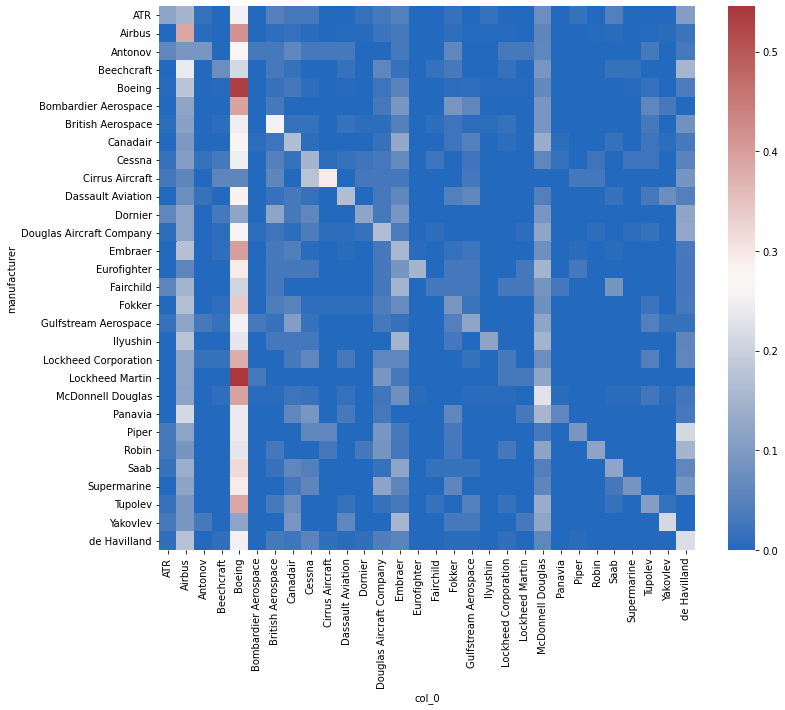

In [65]:
proba_CNN = model_CNN.predict(X_test)
classe_CNN = np.argmax(proba_CNN, axis=1)
lab_classe_CNN = np.array(labels_test.astype('category').cat.categories[classe_CNN])

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(labels_test,
                        lab_classe_CNN,
                        normalize='index'),
            cmap='vlag',
            ax=ax);

Confusion matrix on test sample from the model coming from Transfer :

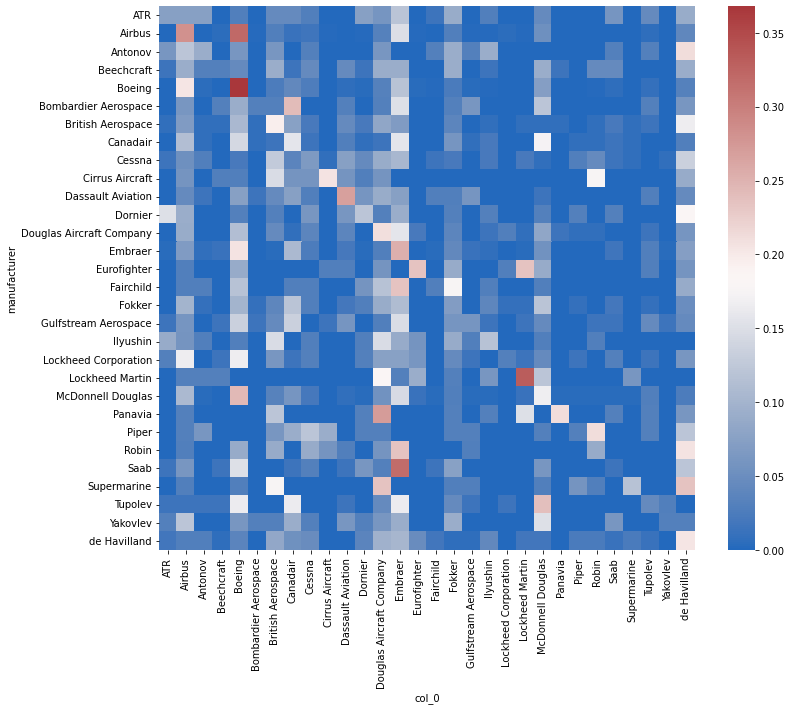

In [99]:
proba_Transfer = model.predict(X_test)
classe_Transfer = np.argmax(proba_Transfer, axis=1)
lab_classe_Transfer = np.array(labels_test.astype('category').cat.categories[classe_Transfer])

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(labels_test,
                        lab_classe_Transfer,
                        normalize='index'),
            cmap='vlag',
            ax=ax);

Our initial CNN model has a higher accuracy than the new model.

In [100]:
print(f"Accuracy of our initial CNN: {round(100*np.mean(lab_classe_CNN == labels_test), 2)} %")
print(f"Accuracy of the Transfer Learning Model : {round(100*np.mean(lab_classe_Transfer == labels_test), 2)} %")

Accuracy of our initial CNN: 26.7 %
Accuracy of the Transfer Learning Model : 21.15 %


Another interesting statistics is the recall, meaning the success rate of the model conditional on a certain class. The next code compute the recall for each class of manufacturer.

In [101]:
recalls_CNN = []
recalls_Transfer = []
for i in labels_test.unique():
  recalls_CNN.append(np.mean((lab_classe_CNN == labels_test)[labels_test == i]))
  recalls_Transfer.append(np.mean((lab_classe_Transfer == labels_test)[labels_test == i]))

The initial model make less mistake when the class is "Cirrus Aircraft" or "British Aerospace". The model coming from Transfer make less mistake when the class is "Lockheed Martin" or "Dassault Aviation".

Text(0.5, 1.0, 'Recall by manufacturer - Initial CNN model')

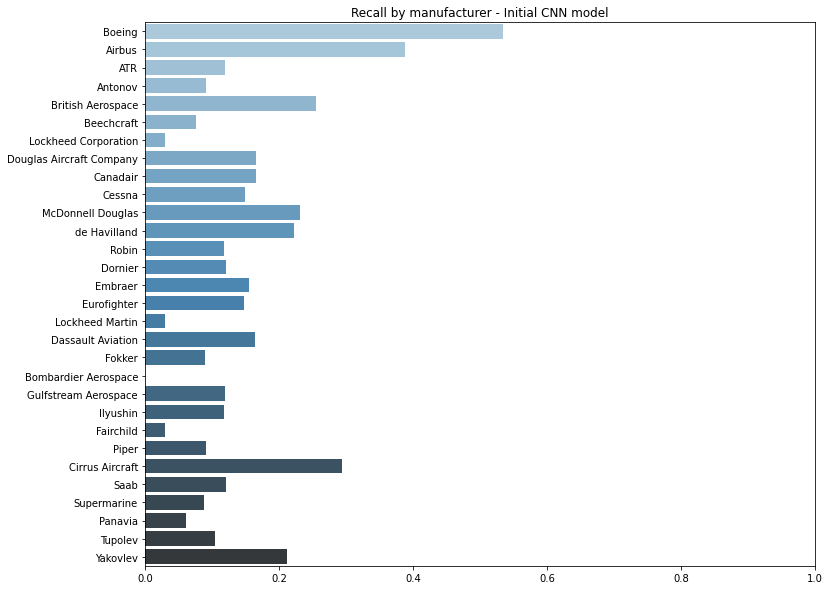

In [102]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.barplot(y=labels_test.unique(), x=recalls_CNN, palette="Blues_d")
ax.set(xlim=(0, 1))
ax.set_title("Recall by manufacturer - Initial CNN model")

Text(0.5, 1.0, 'Recall by manufacturer - Transfer Learning Model')

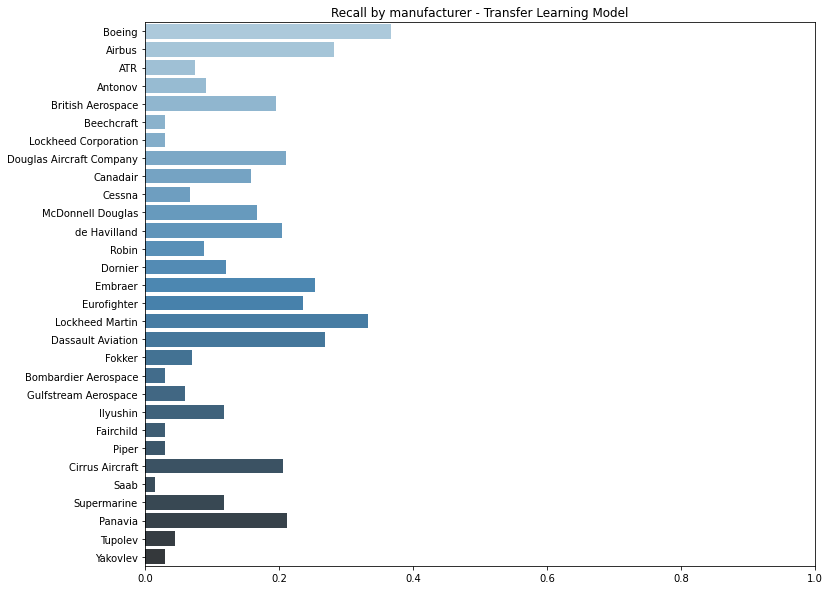

In [103]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.barplot(y=labels_test.unique(), x=recalls_Transfer, palette="Blues_d")
ax.set(xlim=(0, 1))
ax.set_title("Recall by manufacturer - Transfer Learning Model")